In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
PATH = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

In [3]:
#PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.

In [4]:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

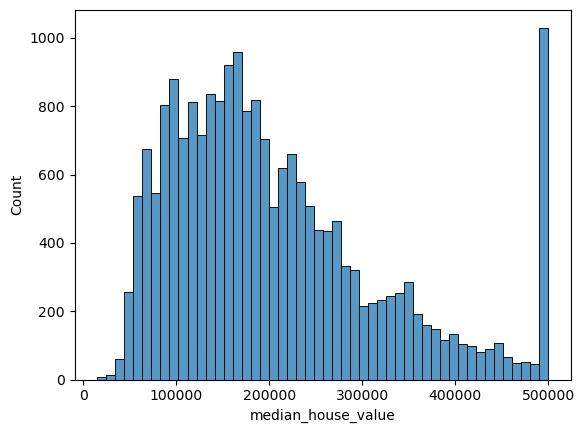

In [5]:
sns.histplot(df["median_house_value"], bins=50)

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

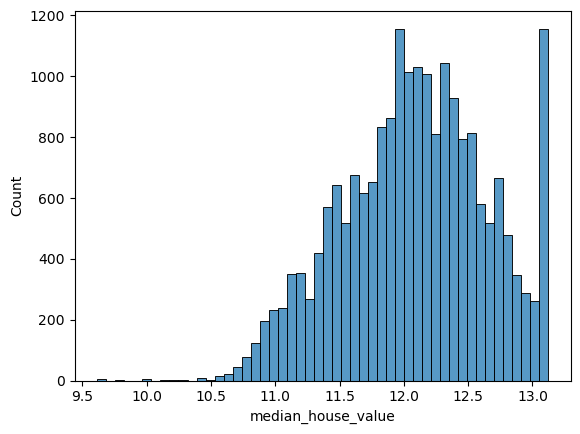

In [6]:
sns.histplot(np.log1p(df["median_house_value"]), bins=50)

In [7]:
df["median_house_value"] = np.log1p(df["median_house_value"])

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["median_house_value"].values
y_val = df_val["median_house_value"].values
y_test = df_test["median_house_value"].values

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

In [8]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[features].to_dict(orient='records')
val_dict = df_val[features].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the ``median_house_value`` variable.

Train a model with ``max_depth=1``

In [9]:
# Training the regression model
# Inspection
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



c:\Users\Pastor\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2
Train a random forest model with these parameters:

- ``n_estimators=10``
- ``random_state=1``
- ``n_jobs=-1`` (optional - to make training faster)
What's the RMSE of this model on validation?

In [13]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [14]:
y_pred = rf.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False).round(2)

0.25

## Question 3

Now, let's experiment with the n_estimators parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

In [15]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

In [17]:
df_scores

,n_estimators,rmse
0,10,0.245738
1,20,0.239262
2,30,0.235717
3,40,0.234583
4,50,0.233104
5,60,0.232843
6,70,0.232384
7,80,0.232527
8,90,0.232215
9,100,0.231968


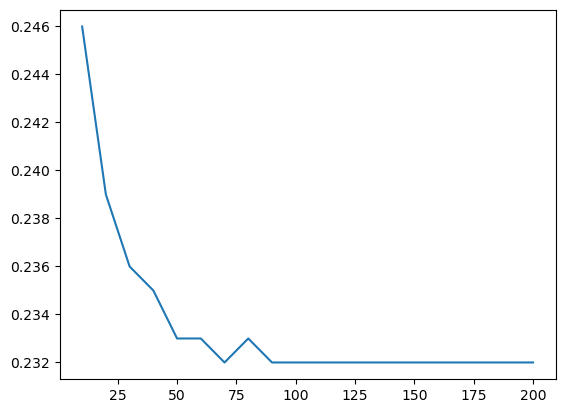

In [16]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

## Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
- Fix the random seed: random_state=1

In [18]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

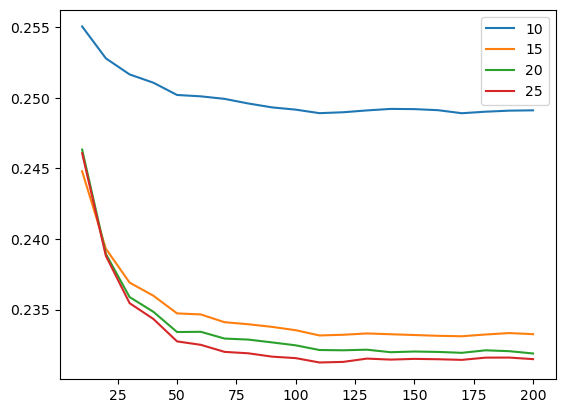

In [19]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

- Train the model with these parametes:
    - n_estimators=10,
    - max_depth=20,
    - random_state=1,
    - n_jobs=-1 (optional)
- Get the feature importance information from this model

In [20]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
rf.feature_importances_

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02,
       3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04,
       4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02,
       2.05364687e-02])

In [22]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_

c:\Users\Pastor\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
df_importances.sort_values(by=["importance"], ascending=False)

,feature,importance
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094
10,population,0.030918
12,total_rooms,0.020536
11,total_bedrooms,0.019041
0,households,0.016957
9,ocean_proximity=NEAR OCEAN,0.004228


## Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

In [24]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [29]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [30]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [31]:
scores = {}

In [32]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [33]:
scores['eta=0.3'] = parse_xgb_output(output)

In [34]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [35]:
scores['eta=0.1'] = parse_xgb_output(output)

In [36]:
scores

{'eta=0.3':     num_iter  train_auc  val_auc
 0          0    8.12733  8.13245
 1          5    1.40218  1.40741
 2         10    0.34481  0.35782
 3         15    0.23555  0.26044
 4         20    0.21580  0.24624
 5         25    0.20395  0.24099
 6         30    0.19440  0.23741
 7         35    0.18637  0.23562
 8         40    0.17983  0.23419
 9         45    0.17468  0.23279
 10        50    0.16934  0.23097
 11        55    0.16546  0.23039
 12        60    0.16177  0.22950
 13        65    0.15762  0.22857
 14        70    0.15323  0.22787
 15        75    0.15010  0.22755
 16        80    0.14564  0.22611
 17        85    0.14166  0.22579
 18        90    0.13892  0.22628
 19        95    0.13553  0.22630
 20        99    0.13299  0.22610,
 'eta=0.1':     num_iter  train_auc   val_auc
 0          0   10.44372  10.44938
 1          5    6.17513   6.17987
 2         10    3.65741   3.66135
 3         15    2.17500   2.17928
 4         20    1.30499   1.31054
 5         25    0.

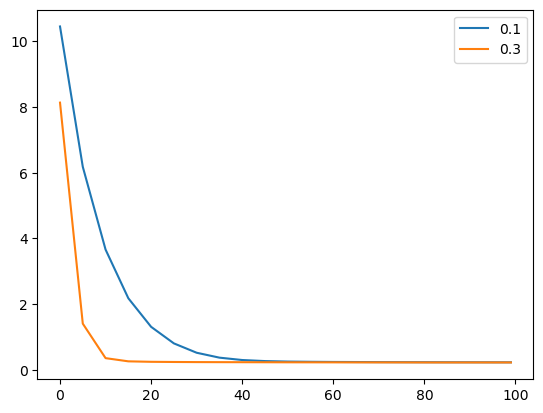

In [37]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()

#plt.ylim([0, 2])
#plt.xlim([20, 60])

In [39]:
scores['eta=0.3']

,num_iter,train_auc,val_auc
0,0,8.12733,8.13245
1,5,1.40218,1.40741
2,10,0.34481,0.35782
3,15,0.23555,0.26044
4,20,0.21580,0.24624
5,25,0.20395,0.24099
6,30,0.19440,0.23741
7,35,0.18637,0.23562
8,40,0.17983,0.23419
9,45,0.17468,0.23279


In [40]:
scores['eta=0.1']

,num_iter,train_auc,val_auc
0,0,10.44372,10.44938
1,5,6.17513,6.17987
2,10,3.65741,3.66135
3,15,2.17500,2.17928
4,20,1.30499,1.31054
5,25,0.79933,0.80657
6,30,0.51144,0.52189
7,35,0.35700,0.37264
8,40,0.27984,0.30053
9,45,0.24350,0.26829
